In [356]:
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [357]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [358]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

target_class = 4
class_indices = [i for i, (_, label) in enumerate(mnist) if label == target_class]
unseen_indices = [i for i, (_, label) in enumerate(mnist) if label != target_class]




In [458]:
train_idxs = class_indices[:4]
unseen_idxs = unseen_indices[:200]

train_subset = Subset(mnist, train_idxs)
unseen_subset = Subset(mnist, unseen_idxs)

train_loader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
unseen_loader = DataLoader(unseen_subset, batch_size=len(unseen_subset), shuffle=False)

In [459]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 784),
            nn.Tanh()
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, z):
        out = self.net(z)
        return out

In [460]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.net(x)
        return out

In [461]:
Gen = Generator().to(device)
Disc = Discriminator().to(device)

criterion = nn.BCELoss()

optim_g = optim.Adam(Gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_d = optim.Adam(Disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

fixed_noise = torch.randn(5, 100, device=device)


In [462]:
epochs = 500
losses_G = [] # List of avg values per epoch
losses_D = [] 

for epoch in range(epochs):
    epoch_losses_G = []
    epoch_losses_D = []
    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.view(-1, 784).to(device)
        batch_size_curr = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size_curr, 1, device=device)
        fake_labels = torch.zeros(batch_size_curr, 1, device=device)

        z = torch.randn(batch_size_curr, 100, device=device)
        fake_imgs = Gen(z)

        D_real = Disc(real_imgs)
        D_fake = Disc(fake_imgs.detach())

        loss_D_real = criterion(D_real, real_labels)
        loss_D_fake = criterion(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        optim_d.zero_grad()
        loss_D.backward()
        optim_d.step()

        z = torch.randn(batch_size_curr, 100, device=device)
        fake_imgs = Gen(z)
        D_fake = Disc(fake_imgs)

        loss_G = criterion(D_fake, real_labels)

        optim_g.zero_grad()
        loss_G.backward()
        optim_g.step()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch {batch_idx}/{len(train_loader)} "
                  f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}, "
                  f"D(x): {D_real.mean().item():.4f}, D(G(z)): {D_fake.mean().item():.4f}")
        epoch_losses_D.append(loss_D.item())
        epoch_losses_G.append(loss_G.item())

    losses_D.append(np.mean(np.array(epoch_losses_D)))
    losses_G.append(np.mean(np.array(epoch_losses_G)))

    # with torch.no_grad():
    #     fake_samples = Gen(fixed_noise).view(-1, 1, 28, 28)
    #     grid = torch.cat([fake_samples[i] for i in range(5)], dim=2)
    #     plt.imshow(grid.squeeze().cpu().numpy(), cmap="gray")
    #     plt.title(f"Epoch {epoch+1}")
    #     plt.show()

Epoch [1/500] Batch 0/1 Loss D: 1.3789, Loss G: 0.6935, D(x): 0.5037, D(G(z)): 0.4998
Epoch [2/500] Batch 0/1 Loss D: 1.2283, Loss G: 0.6924, D(x): 0.5862, D(G(z)): 0.5004
Epoch [3/500] Batch 0/1 Loss D: 1.0991, Loss G: 0.6911, D(x): 0.6677, D(G(z)): 0.5010
Epoch [4/500] Batch 0/1 Loss D: 0.9898, Loss G: 0.6891, D(x): 0.7465, D(G(z)): 0.5020
Epoch [5/500] Batch 0/1 Loss D: 0.9009, Loss G: 0.6859, D(x): 0.8188, D(G(z)): 0.5036
Epoch [6/500] Batch 0/1 Loss D: 0.8345, Loss G: 0.6810, D(x): 0.8785, D(G(z)): 0.5061
Epoch [7/500] Batch 0/1 Loss D: 0.7923, Loss G: 0.6744, D(x): 0.9216, D(G(z)): 0.5095
Epoch [8/500] Batch 0/1 Loss D: 0.7738, Loss G: 0.6697, D(x): 0.9494, D(G(z)): 0.5119
Epoch [9/500] Batch 0/1 Loss D: 0.7708, Loss G: 0.6584, D(x): 0.9659, D(G(z)): 0.5177
Epoch [10/500] Batch 0/1 Loss D: 0.7776, Loss G: 0.6397, D(x): 0.9752, D(G(z)): 0.5275
Epoch [11/500] Batch 0/1 Loss D: 0.7868, Loss G: 0.6221, D(x): 0.9802, D(G(z)): 0.5368
Epoch [12/500] Batch 0/1 Loss D: 0.8045, Loss G: 0.6

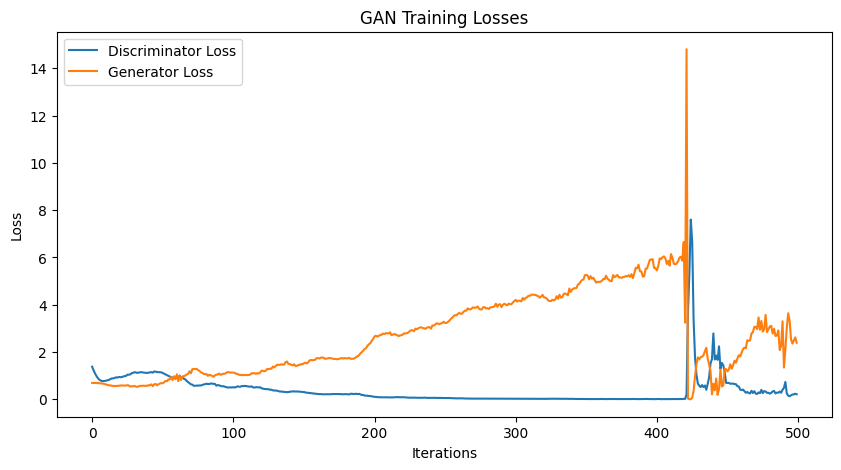

In [463]:
plt.figure(figsize=(10,5))
plt.plot(losses_D, label="Discriminator Loss")
plt.plot(losses_G, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.show()

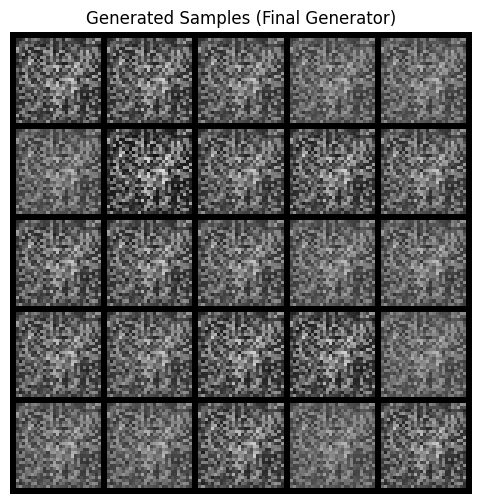

In [464]:
import torchvision.utils as vutils

z = torch.randn(25, 100, device=device)
with torch.no_grad():
    fake_imgs = Gen(z).view(-1, 1, 28, 28)

grid = vutils.make_grid(fake_imgs, nrow=5, normalize=True, value_range=(-1, 1))

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.axis("off")
plt.title("Generated Samples (Final Generator)")
plt.show()


In [465]:
# import torch.nn.functional as F

Disc.eval()
all_scores = []
with torch.no_grad():
    for x, _ in unseen_loader:
        x = x.view(-1, 784).to(device)
        scores = Disc(x)  # shape [batch, 1]
        all_scores.append(scores.cpu())

all_scores = torch.cat(all_scores).squeeze()

print("Discriminator scores on unseen data (mean):", all_scores.mean().item())
print("Sample of scores:", all_scores[:10])


Discriminator scores on unseen data (mean): 0.4050706624984741
Sample of scores: tensor([0.0263, 0.1408, 0.5350, 0.7130, 0.0517, 0.6068, 0.0238, 0.5769, 0.4061,
        0.2791])


In [466]:
# Compare with training data
train_scores = []
with torch.no_grad():
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)
        train_scores.append(Disc(x).cpu())
train_scores = torch.cat(train_scores).squeeze()

print("Train set mean score:", train_scores.mean().item())
print("Unseen set mean score:", all_scores.mean().item())


Train set mean score: 0.9685047268867493
Unseen set mean score: 0.4050706624984741
